# TKU 布料瑕疵偵測 Notebook
本 Notebook 依 README 的資料夾規範進行：
- 讀取與擴增訓練資料、訓練輕量 U-Net
- 偵測瑕疵區域、儲存結果影像、計算 Accuracy/Precision/Recall
- 影片瑕疵偵測並輸出結果影片
- 於需要處理引入檔案時，請將影像放置於 `texture_train_images/` 與 `texture_test_images/`，影片於 `texture_test_videos/`；模型權重於 `tinyunet_weights.pth`。

Loaded base images: 2
Augmented samples: 100
Device: cpu
Augmented samples: 100
Device: cpu
Epoch 1/10 Train BCE 0.6029 Dice 0.9079 | Val BCE 0.7270 Dice 0.9369
Epoch 1/10 Train BCE 0.6029 Dice 0.9079 | Val BCE 0.7270 Dice 0.9369
Epoch 2/10 Train BCE 0.4431 Dice 0.8910 | Val BCE 0.6110 Dice 0.9406
Epoch 2/10 Train BCE 0.4431 Dice 0.8910 | Val BCE 0.6110 Dice 0.9406
Epoch 3/10 Train BCE 0.3908 Dice 0.8656 | Val BCE 0.4069 Dice 0.8947
Epoch 3/10 Train BCE 0.3908 Dice 0.8656 | Val BCE 0.4069 Dice 0.8947
Epoch 4/10 Train BCE 0.3431 Dice 0.8377 | Val BCE 0.3385 Dice 0.8278
Epoch 4/10 Train BCE 0.3431 Dice 0.8377 | Val BCE 0.3385 Dice 0.8278
Epoch 5/10 Train BCE 0.3031 Dice 0.8196 | Val BCE 0.3021 Dice 0.8087
Epoch 5/10 Train BCE 0.3031 Dice 0.8196 | Val BCE 0.3021 Dice 0.8087
Epoch 6/10 Train BCE 0.2695 Dice 0.8033 | Val BCE 0.2986 Dice 0.7957
Epoch 6/10 Train BCE 0.2695 Dice 0.8033 | Val BCE 0.2986 Dice 0.7957
Epoch 7/10 Train BCE 0.2387 Dice 0.7838 | Val BCE 0.2204 Dice 0.7610
Epoch 7/10 

C:\Users\timra\AppData\Local\Temp\ipykernel_3208\3757950015.py:202: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\3757950015.py:202: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\3757950015.py:202: UserWarning: Glyph 25913 (\N{CJK UNIFIED IDEOGRAPH-6539}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\3757950015.py:202: UserWarning: Glyph 33391 (\N{CJK UNIFIED IDEOGRAPH-826F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\3757950015.py:202: UserWarning: Glyph 32011 (\N{CJK UNIFIED IDEOGRAPH-7D0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\i

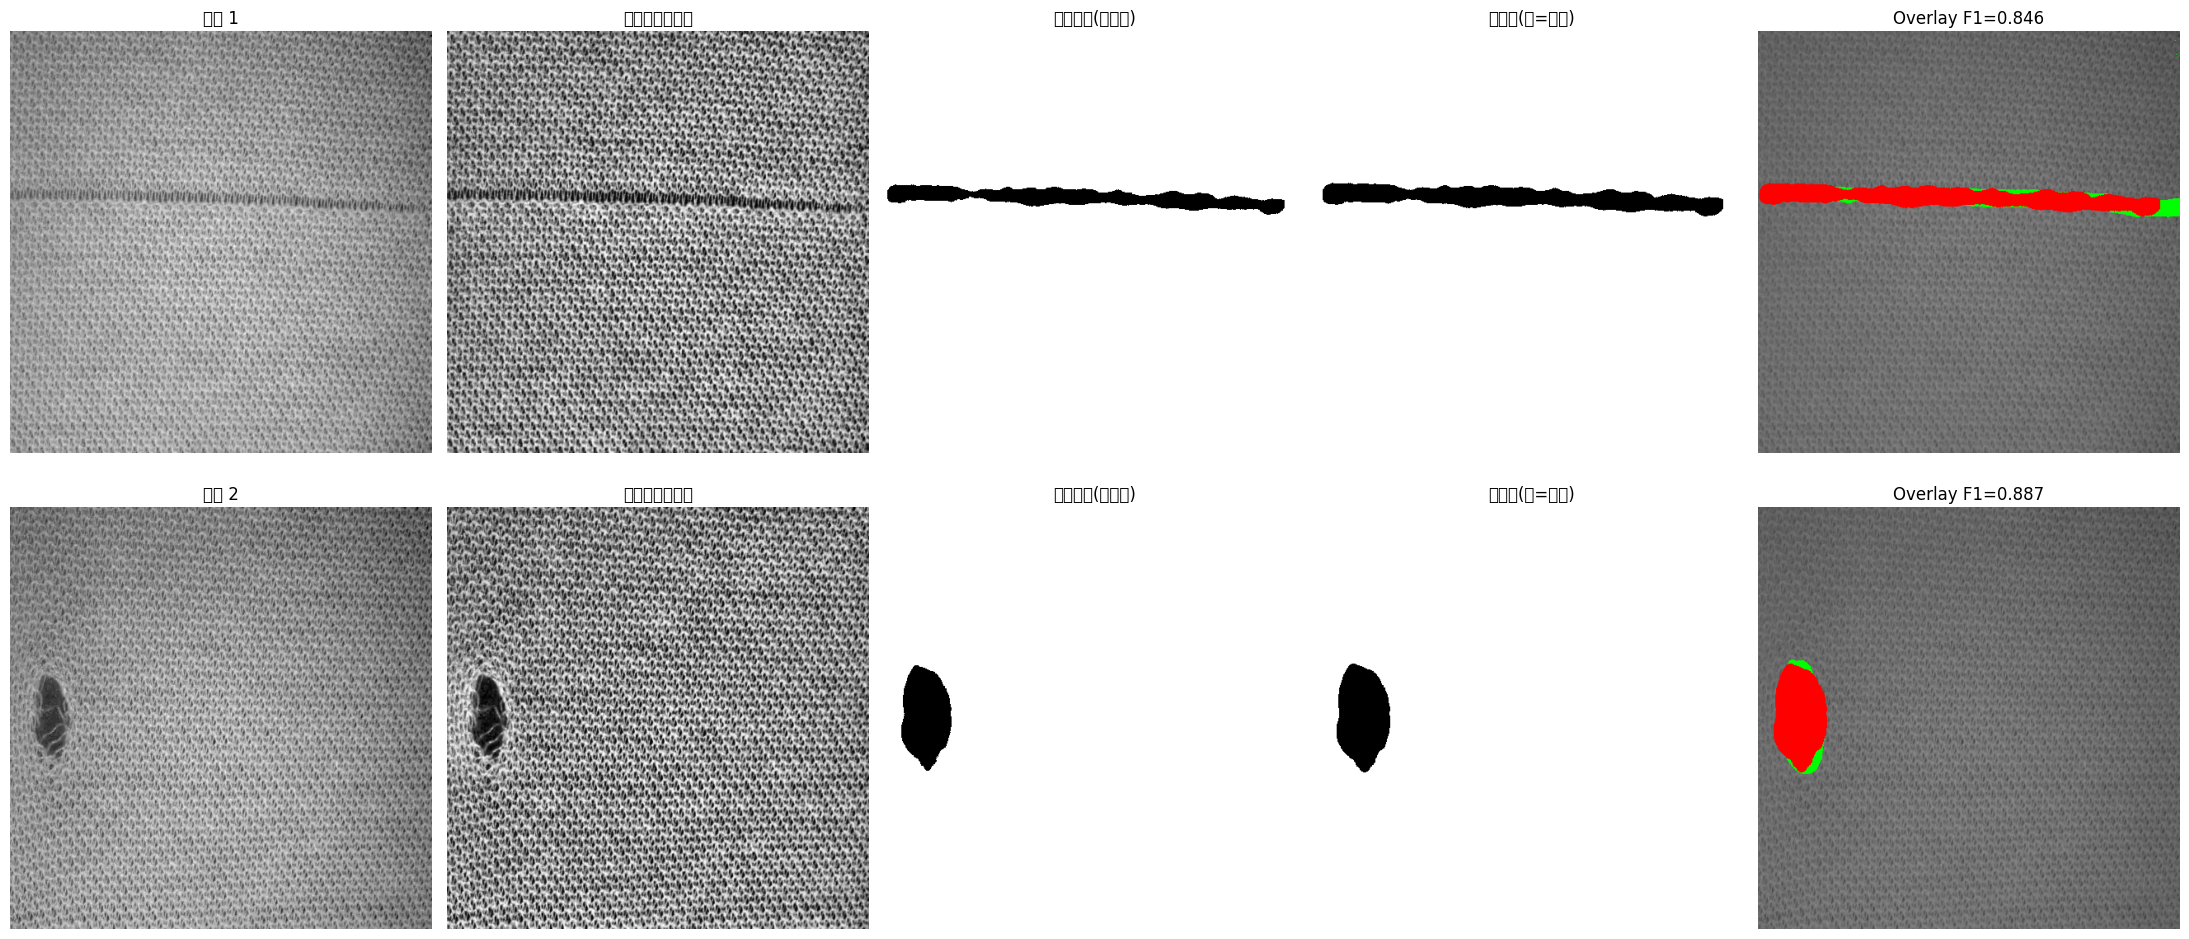

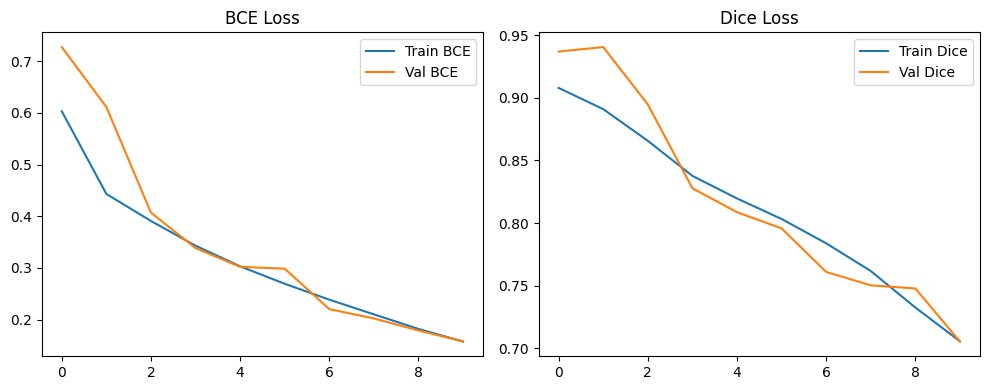

完成: 產生擴增資料並訓練模型。缺陷以黑色顯示。已加入後處理去除噪點並膨脹大區域邊緣。


In [13]:
# 擴增原始 2 張灰階影像至 100 筆並訓練輕量 U-Net
# 缺陷顯示規則: 0 = 缺陷(黑), 255 = 非缺陷(白)
# -------------------------------------------------------------
import os, random, cv2, numpy as np, matplotlib.pyplot as plt
random.seed(42); np.random.seed(42)
# Resolve base image directory robustly (per README)
candidates = ['./texture_train_images', './texture_train_images/', './texture train images', './texture train images/']
BASE_DIR = None
for _c in candidates:
    if os.path.isdir(_c):
        BASE_DIR = _c
        break
if BASE_DIR is None:
    raise FileNotFoundError('請建立並放置影像於 texture_train_images/ (支援容錯)')
IMG_FILES = ['image1.png','image2.png']
GT_FILES  = ['image1_groundtruth.png','image2_groundtruth.png']
imgs = []; gts = []
for f, g in zip(IMG_FILES, GT_FILES):
    ip = os.path.join(BASE_DIR,f)
    gp = os.path.join(BASE_DIR,g)
    im = cv2.imread(ip, cv2.IMREAD_UNCHANGED)
    if im is None: raise FileNotFoundError(ip)
    if im.ndim==3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gt = cv2.imread(gp, cv2.IMREAD_UNCHANGED) if os.path.isfile(gp) else None
    if gt is None: gt = np.ones_like(im,dtype=np.uint8)*255
    if gt.ndim==3: gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    gt = cv2.resize(gt,(im.shape[1],im.shape[0]),interpolation=cv2.INTER_NEAREST)
    imgs.append(im); gts.append(gt)
print('Loaded base images:', len(imgs))
# -------- 紋理正規化 (改良版: 保留缺陷特徵) --------
def texture_normalize(gray, open_size=51):
    """使用 top-hat 變換保留局部異常，避免過度均質化"""
    k = max(3, open_size|1)
    ker = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(k,k))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, ker)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, ker)
    norm = cv2.add(gray, tophat)
    norm = cv2.subtract(norm, blackhat)
    norm = cv2.GaussianBlur(norm, (3,3), 0.5)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm = clahe.apply(norm)
    return norm
# -------- 合成缺陷 (線/孔/斑點/裂紋) --------
def synth_defects(img, mask, max_ops=3):
    h,w = img.shape
    out = img.copy(); m = mask.copy()
    for _ in range(random.randint(1,max_ops)):
        t = random.choice(['line','hole','dots','crack'])
        if t=='line':
            x1,y1 = random.randint(0,w-1), random.randint(0,h-1)
            x2,y2 = random.randint(0,w-1), random.randint(0,h-1)
            thick = random.randint(2,7)
            cv2.line(out,(x1,y1),(x2,y2),color=random.randint(0,35),thickness=thick)
            cv2.line(m,(x1,y1),(x2,y2),color=0,thickness=thick)
        elif t=='hole':
            cx,cy = random.randint(0,w-1), random.randint(0,h-1); r=random.randint(10,28)
            cv2.circle(out,(cx,cy),r,color=random.randint(0,40),thickness=-1)
            cv2.circle(m,(cx,cy),r,color=0,thickness=-1)
        elif t=='dots':
            for __ in range(random.randint(8,25)):
                dx,dy = random.randint(0,w-1), random.randint(0,h-1)
                out[dy,dx]=random.randint(0,50); m[dy,dx]=0
        elif t=='crack':
            pts=[]; steps=random.randint(5,12); x,y=random.randint(0,w-1),random.randint(0,h-1)
            for __ in range(steps):
                pts.append((x,y)); x+=random.randint(-14,14); y+=random.randint(-14,14)
                x=max(0,min(w-1,x)); y=max(0,min(h-1,y))
            for a,b in zip(pts[:-1],pts[1:]):
                cv2.line(out,a,b,color=random.randint(0,30),thickness=random.randint(1,4))
                cv2.line(m,a,b,color=0,thickness=random.randint(1,4))
    return out,m
# -------- 幾何 + 強度擴增 --------
def aug_geom_intensity(img, mask):
    h,w = img.shape; k=random.randint(0,3)
    img2=np.rot90(img,k); mask2=np.rot90(mask,k)
    if random.random()<0.5: img2=np.flipud(img2); mask2=np.flipud(mask2)
    if random.random()<0.5: img2=np.fliplr(img2); mask2=np.fliplr(mask2)
    scale=random.uniform(0.85,1.25); nh,nw=int(h*scale),int(w*scale)
    img_rs=cv2.resize(img2,(nw,nh),interpolation=cv2.INTER_LINEAR); mask_rs=cv2.resize(mask2,(nw,nh),interpolation=cv2.INTER_NEAREST)
    canvas_i=np.full((h,w),np.mean(img_rs),dtype=img.dtype); canvas_m=np.full((h,w),255,dtype=mask.dtype)
    y0=(h-nh)//2; x0=(w-nw)//2; y1=y0+nh; x1=x0+nw
    y0=max(0,y0); x0=max(0,x0); y1=min(h,y1); x1=min(w,x1)
    img_crop=img_rs[:y1-y0,:x1-x0]; mask_crop=mask_rs[:y1-y0,:x1-x0]
    canvas_i[y0:y1,x0:x1]=img_crop; canvas_m[y0:y1,x0:x1]=mask_crop
    img2,mask2=canvas_i,canvas_m
    if random.random()<0.8:
        gamma=random.uniform(0.7,1.5); g=(img2/255.0)**gamma*255; img2=np.clip(g,0,255).astype(np.uint8)
    if random.random()<0.6:
        noise=np.random.normal(0,random.uniform(3,12),img2.shape); img2=np.clip(img2+noise,0,255).astype(np.uint8)
    if random.random()<0.4: img2=cv2.GaussianBlur(img2,(3,3),0)
    if random.random()<0.5:
        alpha=random.uniform(0.85,1.3); beta=random.uniform(-20,20); img2=np.clip(alpha*img2+beta,0,255).astype(np.uint8)
    return img2,mask2
# -------- 生成擴增樣本 --------
N_SAMPLES=100
augX=[]; augY=[]
base_norm=[texture_normalize(im) for im in imgs]
for i in range(N_SAMPLES):
    idx=random.randint(0,len(base_norm)-1)
    im=base_norm[idx]; gt=gts[idx]
    im_a,gt_a=aug_geom_intensity(im,gt)
    if random.random()<0.9: im_a,gt_a=synth_defects(im_a,gt_a,max_ops=random.randint(1,4))
    augX.append(im_a); augY.append(gt_a)
print('Augmented samples:', len(augX))
# -------- 建立 PyTorch 資料集 --------
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
device='cuda' if torch.cuda.is_available() else 'cpu'; print('Device:',device)
class DefectDataset(Dataset):
    def __init__(self, imgs, masks): self.imgs=imgs; self.masks=masks
    def __len__(self): return len(self.imgs)
    def __getitem__(self,i):
        im=self.imgs[i].astype(np.float32)/255.0
        m=(self.masks[i]==0).astype(np.float32)
        return torch.from_numpy(im[None,...]), torch.from_numpy(m[None,...])
# split train/val
indices=list(range(N_SAMPLES)); random.shuffle(indices)
val_n=int(N_SAMPLES*0.15); val_set=set(indices[:val_n])
trainX=[augX[i] for i in indices if i not in val_set]; trainY=[augY[i] for i in indices if i not in val_set]
valX=[augX[i] for i in indices if i in val_set]; valY=[augY[i] for i in indices if i in val_set]
train_ds=DefectDataset(trainX,trainY); val_ds=DefectDataset(valX,valY)
train_dl=DataLoader(train_ds,batch_size=8,shuffle=True); val_dl=DataLoader(val_ds,batch_size=8)
# -------- 輕量 U-Net --------
class Block(nn.Module):
    def __init__(self,i,o): super().__init__(); self.c=nn.Sequential(nn.Conv2d(i,o,3,padding=1),nn.BatchNorm2d(o),nn.ReLU(True),nn.Conv2d(o,o,3,padding=1),nn.BatchNorm2d(o),nn.ReLU(True))
    def forward(self,x): return self.c(x)
class TinyUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = Block(1,32)
        self.b2 = Block(32,64)
        self.b3 = Block(64,128)
        self.p = nn.MaxPool2d(2)
        self.up2 = nn.ConvTranspose2d(128,64,2,2)
        self.d2 = Block(128,64)
        self.up1 = nn.ConvTranspose2d(64,32,2,2)
        self.d1 = Block(64,32)
        self.out = nn.Conv2d(32,1,1)
    def forward(self,x):
        e1 = self.b1(x)
        e2 = self.b2(self.p(e1))
        e3 = self.b3(self.p(e2))
        u2 = self.up2(e3)
        u2 = torch.cat([u2,e2],1)
        u2 = self.d2(u2)
        u1 = self.up1(u2)
        u1 = torch.cat([u1,e1],1)
        u1 = self.d1(u1)
        return self.out(u1)
def dice_loss(logits, targets, eps=1e-6):
    probs=torch.sigmoid(logits); num=2*(probs*targets).sum(); den=probs.sum()+targets.sum()+eps; return 1-num/den
model=TinyUNet().to(device); opt=torch.optim.Adam(model.parameters(),lr=1e-3); bce=nn.BCEWithLogitsLoss()
EPOCHS=10; train_hist=[]; val_hist=[]
for ep in range(1,EPOCHS+1):
    model.train(); tb=0; td=0
    for x,y in train_dl: x=x.to(device); y=y.to(device); opt.zero_grad(); o=model(x); lb=bce(o,y); ld=dice_loss(o,y); loss=lb+ld; loss.backward(); opt.step(); tb+=lb.item(); td+=ld.item()
    model.eval(); vb=0; vd=0
    with torch.no_grad():
        for x,y in val_dl: x=x.to(device); y=y.to(device); o=model(x); vb+=bce(o,y).item(); vd+=dice_loss(o,y).item()
    train_hist.append((tb/len(train_dl), td/len(train_dl))); val_hist.append((vb/len(val_dl), vd/len(val_dl)))
    print(f'Epoch {ep}/{EPOCHS} Train BCE {train_hist[-1][0]:.4f} Dice {train_hist[-1][1]:.4f} | Val BCE {val_hist[-1][0]:.4f} Dice {val_hist[-1][1]:.4f}')
# -------- 後處理: 去除噪點並膨脹大區域邊緣 --------
def postprocess_mask(mask_binary, min_area=30, dilate_kernel=5):
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_binary, connectivity=8)
    cleaned = np.zeros_like(mask_binary)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < min_area:
            continue
        else:
            component = (labels == i).astype(np.uint8)
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_kernel, dilate_kernel))
            dilated = cv2.dilate(component, kernel, iterations=1)
            cleaned = cv2.bitwise_or(cleaned, dilated)
    return cleaned

# -------- 生成預測與視覺化 --------
def predict(im):
    im_n=texture_normalize(im); t=torch.from_numpy(im_n.astype(np.float32)/255.0)[None,None,...].to(device)
    with torch.no_grad(): p=torch.sigmoid(model(t))[0,0].cpu().numpy()
    mask_raw=(p>0.5).astype(np.uint8)
    mask_clean = postprocess_mask(mask_raw, min_area=30, dilate_kernel=5)
    mask_out=np.ones_like(im_n,dtype=np.uint8)*255; mask_out[mask_clean==1]=0
    return mask_out, p, mask_raw

fig,axs=plt.subplots(len(imgs),5,figsize=(22,5*len(imgs)))
if len(imgs)==1: axs=axs.reshape(1,5)
for i,(im,gt) in enumerate(zip(imgs,gts)):
    pm,prob,mask_raw=predict(im); im_norm=texture_normalize(im)
    gt_def=(gt==0); pred_def=(pm==0)
    raw_def=(mask_raw==1)
    tp=int(np.logical_and(gt_def,pred_def).sum()); fp=int(np.logical_and(~gt_def,pred_def).sum()); fn=int(np.logical_and(gt_def,~pred_def).sum())
    prec=tp/(tp+fp) if (tp+fp)>0 else 0; rec=tp/(tp+fn) if (tp+fn)>0 else 0; f1=(2*prec*rec)/(prec+rec) if (prec+rec)>0 else 0
    axs[i,0].imshow(im,cmap='gray'); axs[i,0].set_title(f'原始 {i+1}'); axs[i,0].axis('off')
    axs[i,1].imshow(im_norm,cmap='gray'); axs[i,1].set_title('改良紋理正規化'); axs[i,1].axis('off')
    mask_raw_display=np.ones_like(im,dtype=np.uint8)*255; mask_raw_display[raw_def]=0
    axs[i,2].imshow(mask_raw_display,cmap='gray',vmin=0,vmax=255); axs[i,2].set_title('原始預測(有噪點)'); axs[i,2].axis('off')
    axs[i,3].imshow(pm,cmap='gray',vmin=0,vmax=255); axs[i,3].set_title('後處理(黑=缺陷)'); axs[i,3].axis('off')
    overlay=np.stack([im]*3,axis=-1)
    ov=overlay.copy(); ov[gt_def]=[0,255,0]; ov[pred_def]=[255,0,0]
    axs[i,4].imshow(ov); axs[i,4].set_title(f'Overlay F1={f1:.3f}'); axs[i,4].axis('off')
plt.tight_layout(); plt.show()
tr_b=[x[0] for x in train_hist]; tr_d=[x[1] for x in train_hist]; va_b=[x[0] for x in val_hist]; va_d=[x[1] for x in val_hist]
plt.figure(figsize=(10,4)); plt.subplot(1,2,1); plt.plot(tr_b,label='Train BCE'); plt.plot(va_b,label='Val BCE'); plt.legend(); plt.title('BCE Loss');
plt.subplot(1,2,2); plt.plot(tr_d,label='Train Dice'); plt.plot(va_d,label='Val Dice'); plt.legend(); plt.title('Dice Loss'); plt.tight_layout(); plt.show()
print('完成: 產生擴增資料並訓練模型。缺陷以黑色顯示。已加入後處理去除噪點並膨脹大區域邊緣。')

# 擴增與訓練
此單元格會：
- 從訓練資料夾讀取兩張灰階影像與地真值（黑=缺陷、白=背景），按 README 規範容錯資料夾名稱
- 進行紋理正規化、資料擴增（幾何/強度 + 合成缺陷），擴增至 100 筆
- 訓練輕量 U-Net（BCE + Dice），並視覺化訓練/驗證 Loss 曲線
- 生成預測、套用後處理（移除小噪點、膨脹大區域邊緣），並繪製對比圖

In [14]:
# 1) 讀取影像與標準答案 (資料集設定)
import os, glob
import cv2, numpy as np
from pathlib import Path

images = []
ground_truths = []
IMG_FILES = ['image1.png','image2.png']
GT_FILES  = ['image1_groundtruth.png','image2_groundtruth.png']

# 優先使用前一格已載入的 imgs/gts 變數
try:
    if 'imgs' in globals() and 'gts' in globals() and len(imgs)>=2:
        images = [imgs[0], imgs[1]]
        ground_truths = [gts[0], gts[1]]
        print('Dataset loaded from existing variables imgs/gts')
    else:
        raise Exception('fallback to disk')
except Exception:
    # 依 README 容錯資料夾名稱
    candidates = ['./texture_train_images', './texture_train_images/', './texture train images', './texture train images/']
    DATA_DIR = None
    for d in candidates:
        if os.path.isdir(d):
            DATA_DIR = d
            break
    if DATA_DIR is None:
        print('警告: 找不到影像資料夾，請建立 texture_train_images/ 並放置 image1.png/image2.png 與其地真值')
        images = []
        ground_truths = []
    else:
        for f, g in zip(IMG_FILES, GT_FILES):
            ip = os.path.join(DATA_DIR, f)
            gp = os.path.join(DATA_DIR, g)
            im = cv2.imread(ip, cv2.IMREAD_UNCHANGED)
            if im is None:
                raise FileNotFoundError(ip)
            if im.ndim == 3:
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            gt = cv2.imread(gp, cv2.IMREAD_UNCHANGED)
            if gt is None:
                raise FileNotFoundError(gp)
            if gt.ndim == 3:
                gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
            gt = cv2.resize(gt,(im.shape[1],im.shape[0]),interpolation=cv2.INTER_NEAREST)
            images.append(im)
            ground_truths.append(gt)
        print(f'Dataset loaded: {len(images)} images from {DATA_DIR}')

Dataset loaded from existing variables imgs/gts


# 讀取影像與標準答案
此單元格會：
- 優先使用前一格的 `imgs/gts`，否則依 README 容錯查找資料夾並從磁碟載入
- 讀取 `image1.png`, `image2.png` 與其地真值 `image1_groundtruth.png`, `image2_groundtruth.png`
- 將地真值與影像大小對齊（黑=缺陷、白=背景）

In [15]:
# 2) 儲存與載入模型參數 (避免每次重訓)
import torch

WEIGHTS_PATH = './tinyunet_weights.pth'

# 儲存目前模型權重
try:
    torch.save(model.state_dict(), WEIGHTS_PATH)
    print(f'Weights saved to {WEIGHTS_PATH}')
except Exception as e:
    print('Skip saving weights (model not defined yet?):', e)

# 載入權重（若存在）
try:
    m2 = TinyUNet().to(device)
    m2.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
    m2.eval()
    # 用載入權重的模型覆蓋現行模型，提供更快推論
    model = m2
    print(f'Weights loaded from {WEIGHTS_PATH} and model set to eval')
except Exception as e:
    print('Skip loading weights:', e)

Weights saved to ./tinyunet_weights.pth
Weights loaded from ./tinyunet_weights.pth and model set to eval


# 儲存/載入模型權重
此單元格會：
- 儲存目前模型權重至 `tinyunet_weights.pth`
- 若檔案存在，載入權重並將模型設為 eval（避免重訓，推論更快）
- 參考 README：權重檔已在 `.gitignore` 忽略

image1.png: Acc=0.988 Precision=0.825 Recall=0.868
image2.png: Acc=0.995 Precision=0.869 Recall=0.905
image2.png: Acc=0.995 Precision=0.869 Recall=0.905


C:\Users\timra\AppData\Local\Temp\ipykernel_3208\2271799375.py:50: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\2271799375.py:50: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\2271799375.py:50: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\2271799375.py:50: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\2271799375.py:50: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B54}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipyker

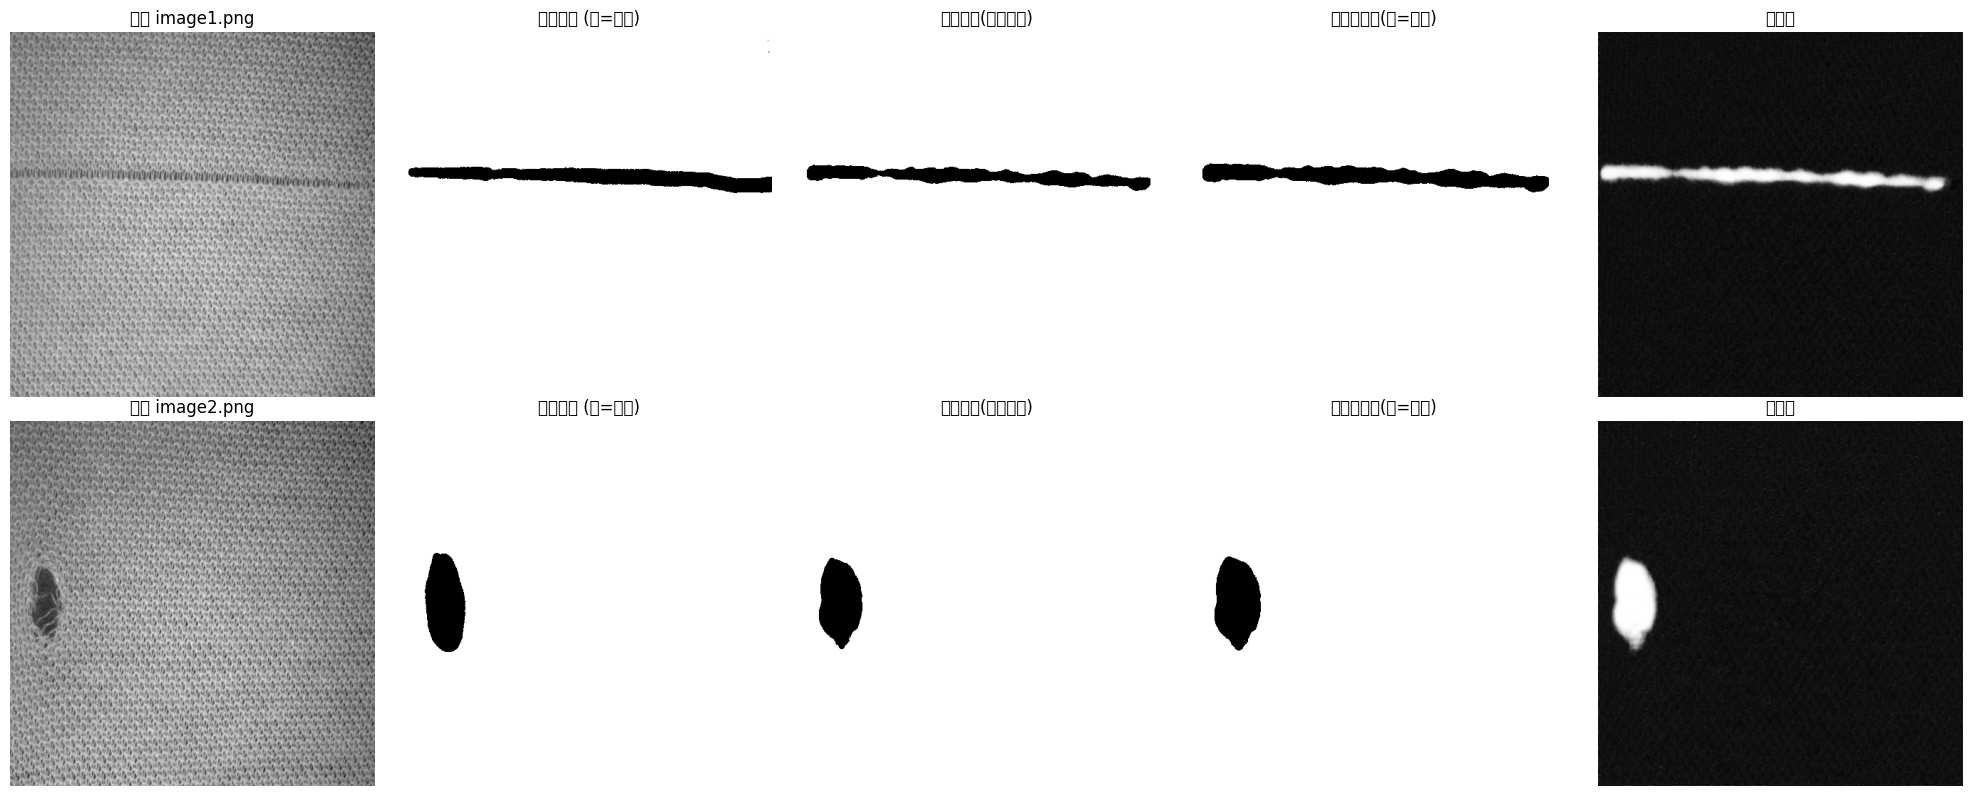

In [16]:
# 3) 影像偵測 + 結果儲存(.png) + 指標(Accuracy/Precision/Recall)
import os
import matplotlib.pyplot as plt

OUT_DIR = './results_images'
os.makedirs(OUT_DIR, exist_ok=True)

# 指標計算輔助

def compute_metrics(pred_mask_u8, gt_u8):
    pred_def = (pred_mask_u8==0)  # 黑=缺陷
    gt_def = (gt_u8==0)
    tp = int(np.logical_and(pred_def, gt_def).sum())
    tn = int(np.logical_and(~pred_def, ~gt_def).sum())
    fp = int(np.logical_and(pred_def, ~gt_def).sum())
    fn = int(np.logical_and(~pred_def, gt_def).sum())
    acc = (tp+tn) / max(1, (tp+tn+fp+fn))
    prec = tp / max(1, (tp+fp))
    rec = tp / max(1, (tp+fn))
    return acc, prec, rec, tp, tn, fp, fn

metrics_list = []

for i, (im, gt) in enumerate(zip(images, ground_truths)):
    # 推論
    pm, prob, mask_raw = predict(im)
    name = IMG_FILES[i]
    # 儲存偵測結果影像
    out_path = os.path.join(OUT_DIR, f'{Path(name).stem}_detected.png')
    cv2.imwrite(out_path, pm)
    # 指標
    acc, prec, rec, tp, tn, fp, fn = compute_metrics(pm, gt)
    metrics_list.append({'name': name, 'acc': acc, 'prec': prec, 'rec': rec, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn})
    print(f"{name}: Acc={acc:.3f} Precision={prec:.3f} Recall={rec:.3f}")

# 4) 對比圖 Plot：原始 / GT / 原始預測 / 後處理遮罩 / 機率圖
fig, axs = plt.subplots(len(images), 5, figsize=(20, 4*len(images)))
if len(images)==1:
    axs = axs.reshape(1,5)
for i, (im, gt) in enumerate(zip(images, ground_truths)):
    pm, prob, mask_raw = predict(im)
    raw_vis = np.ones_like(im, dtype=np.uint8)*255
    raw_vis[mask_raw==1] = 0
    prob_u8 = np.clip(prob*255, 0, 255).astype(np.uint8)
    axs[i,0].imshow(im, cmap='gray'); axs[i,0].set_title(f'原始 {IMG_FILES[i]}'); axs[i,0].axis('off')
    axs[i,1].imshow(gt, cmap='gray', vmin=0, vmax=255); axs[i,1].set_title('標準答案 (黑=缺陷)'); axs[i,1].axis('off')
    axs[i,2].imshow(raw_vis, cmap='gray', vmin=0, vmax=255); axs[i,2].set_title('原始預測(前處理前)'); axs[i,2].axis('off')
    axs[i,3].imshow(pm, cmap='gray', vmin=0, vmax=255); axs[i,3].set_title('後處理遮罩(黑=缺陷)'); axs[i,3].axis('off')
    axs[i,4].imshow(prob_u8, cmap='gray'); axs[i,4].set_title('機率圖'); axs[i,4].axis('off')
plt.tight_layout(); plt.show()

# 影像偵測、儲存與指標
此單元格會：
- 對載入的影像進行偵測，輸出遮罩（黑=缺陷、白=背景）
- 儲存偵測結果影像至 `results_images/`
- 計算 Accuracy/Precision/Recall 並列印
- 繪製原始/GT/原始預測/後處理遮罩/機率圖對比

In [17]:
# 5) 影片瑕疵偵測並輸出影片 (獨立處理區塊)
import cv2, os
import numpy as np

VIDEO_IN  = './input_video.mp4'   # 請將測試影片放置於此路徑
VIDEO_OUT = './output_video_defects.mp4'

if not os.path.isfile(VIDEO_IN):
    print(f'影片檔不存在: {VIDEO_IN}，請放置測試影片後再執行此格')
else:
    cap = cv2.VideoCapture(VIDEO_IN)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, fps, (w, h))

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = frame
        if gray.ndim == 3:
            gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
        # 推論
        mask_out, prob, mask_raw = predict(gray)
        # 疊圖顯示 (紅色標示缺陷)
        overlay = frame.copy()
        overlay[mask_out==0] = [0,0,255]
        writer.write(overlay)
        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f'Processed {frame_idx} frames...')

    cap.release()
    writer.release()
    print(f'完成影片輸出: {VIDEO_OUT}')

影片檔不存在: ./input_video.mp4，請放置測試影片後再執行此格


# 影片瑕疵偵測並輸出
此單元格會：
- 讀取 `VIDEO_IN`（依 README 將影片放置於 `texture_test_videos/` 或根目錄）
- 逐幀偵測瑕疵並將缺陷以紅色標示
- 將結果輸出為 `output_video_defects.mp4`，並顯示處理進度

# 實際測試影像推論與儲存
此單元格會：
- 從 `texture_test_images/` 讀取所有影像（png/jpg/jpeg/bmp/tif/tiff）
- 使用已載入/訓練好的模型進行偵測，輸出黑=缺陷/白=背景的遮罩
- 儲存結果至 `texture_result_images/`，並繪製對比圖
- 若存在對應地真值（同名加 `_groundtruth.png`），則計算 Accuracy/Precision/Recall

共找到 2 張測試影像
ezgif-frame-018.png: 無地真值，僅輸出遮罩影像
ezgif-frame-018.png: 無地真值，僅輸出遮罩影像
ezgif-frame-020.png: 無地真值，僅輸出遮罩影像
ezgif-frame-020.png: 無地真值，僅輸出遮罩影像


C:\Users\timra\AppData\Local\Temp\ipykernel_3208\860291978.py:59: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\860291978.py:59: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\860291978.py:59: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\860291978.py:59: UserWarning: Glyph 34389 (\N{CJK UNIFIED IDEOGRAPH-8655}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3208\860291978.py:59: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
C:\Users\timra\AppData\Local\Temp\ipykernel_3

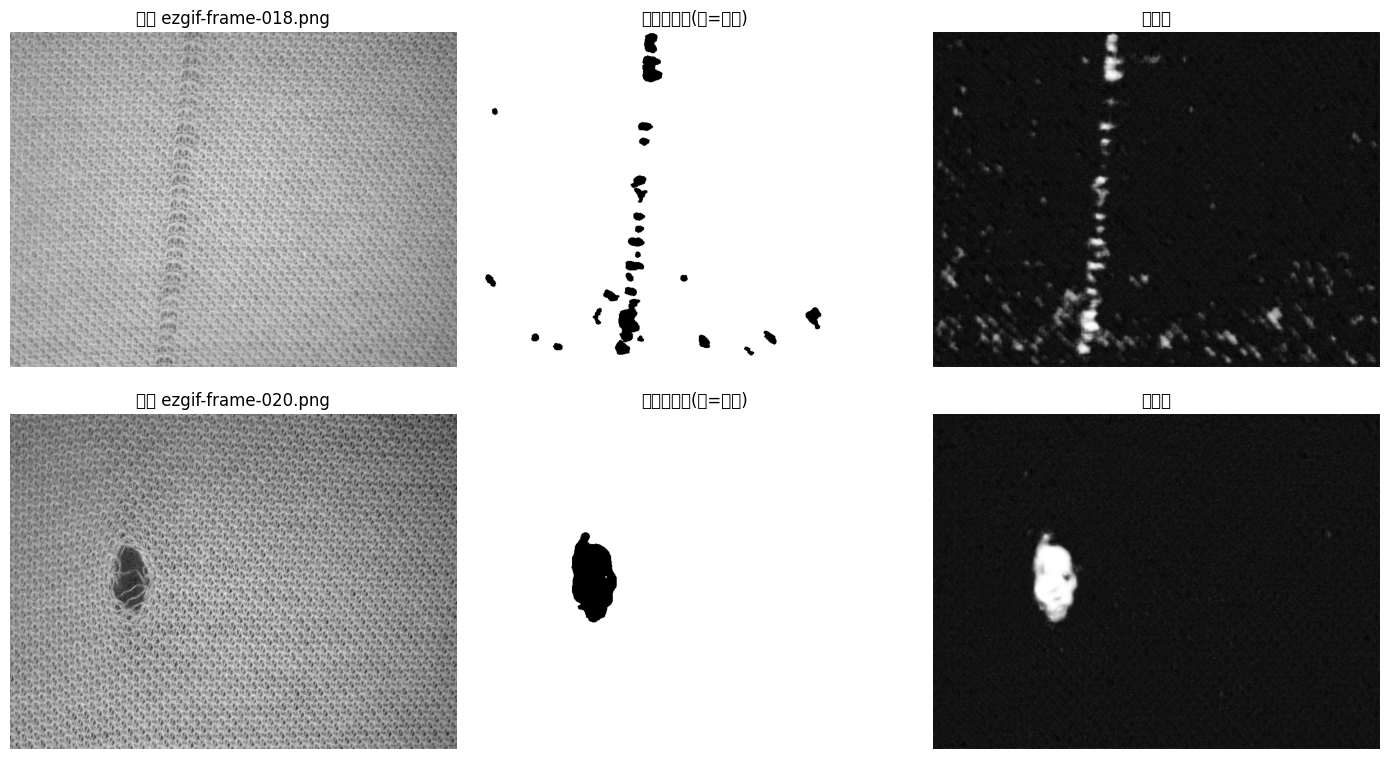

In [18]:
# 6) 從 texture_test_images/ 批次推論、儲存、指標與對比圖
import os, glob, cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

TEST_DIR = './texture_test_images'
OUT_DIR  = './texture_result_images'
os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(OUT_DIR,  exist_ok=True)

exts = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')
files = []
for e in exts: files += glob.glob(os.path.join(TEST_DIR, e))
files = sorted(files)
if len(files)==0:
    print(f'警告: {TEST_DIR} 沒有影像，請放置測試影像後重跑此格')
else:
    print(f'共找到 {len(files)} 張測試影像')
    metrics_list = []
    fig, axs = plt.subplots(len(files), 3, figsize=(14, 4*len(files)))
    if len(files)==1: axs = axs.reshape(1,3)
    for i, ip in enumerate(files):
        im = cv2.imread(ip, cv2.IMREAD_UNCHANGED)
        if im is None:
            print('跳過 (讀取失敗):', ip)
            continue
        if im.ndim==3: im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        pm, prob, mask_raw = predict(im)
        # 儲存結果遮罩
        out_path = os.path.join(OUT_DIR, f'{Path(ip).stem}_detected.png')
        cv2.imwrite(out_path, pm)
        # 嘗試載入地真值（同名加 _groundtruth.png）
        gt_path = os.path.join(TEST_DIR, f'{Path(ip).stem}_groundtruth.png')
        has_gt = os.path.isfile(gt_path)
        if has_gt:
            gt = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)
            if gt is not None and gt.ndim==3: gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
            if gt is None: has_gt = False
        # 指標（若有 GT）
        if has_gt:
            gt = cv2.resize(gt,(im.shape[1],im.shape[0]),interpolation=cv2.INTER_NEAREST)
            pred_def = (pm==0)
            gt_def   = (gt==0)
            tp = int(np.logical_and(pred_def, gt_def).sum())
            tn = int(np.logical_and(~pred_def, ~gt_def).sum())
            fp = int(np.logical_and(pred_def, ~gt_def).sum())
            fn = int(np.logical_and(~pred_def, gt_def).sum())
            acc = (tp+tn) / max(1, (tp+tn+fp+fn))
            prec = tp / max(1, (tp+fp))
            rec = tp / max(1, (tp+fn))
            metrics_list.append({'name': Path(ip).name, 'acc': acc, 'prec': prec, 'rec': rec, 'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn})
            print(f"{Path(ip).name}: Acc={acc:.3f} Precision={prec:.3f} Recall={rec:.3f}")
        else:
            print(f'{Path(ip).name}: 無地真值，僅輸出遮罩影像')
        # 對比圖：原始 / 後處理遮罩 / 機率圖
        prob_u8 = np.clip(prob*255, 0, 255).astype(np.uint8)
        axs[i,0].imshow(im, cmap='gray'); axs[i,0].set_title(f'原始 {Path(ip).name}'); axs[i,0].axis('off')
        axs[i,1].imshow(pm, cmap='gray', vmin=0, vmax=255); axs[i,1].set_title('後處理遮罩(黑=缺陷)'); axs[i,1].axis('off')
        axs[i,2].imshow(prob_u8, cmap='gray'); axs[i,2].set_title('機率圖'); axs[i,2].axis('off')
    plt.tight_layout(); plt.show()

# 影片批次偵測（texture_test_videos）並輸出
此單元格會：
- 於 `texture_test_videos/` 搜尋影片（avi/mp4），預設處理第一個找到的檔案
- 逐幀偵測瑕疵並以紅色標示，輸出至 `output_video_defects.mp4`
- 若資料夾不存在或無檔案，顯示提示

In [ ]:
# 7) 從 texture_test_videos/ 推論並輸出影片
import os, glob, cv2

#VID_DIR = './texture_test_videos'
os.makedirs(VID_DIR, exist_ok=True)

candidates = glob.glob(os.path.join(VID_DIR, '*.mp4')) + glob.glob(os.path.join(VID_DIR, '*.avi'))
if len(candidates)==0:
    print(f'警告: {VID_DIR} 沒有影片，請放置測試影片（mp4/avi）後重跑此格')
else:
    VIDEO_IN  = candidates[0]
    VIDEO_OUT = './output_video_defects.mp4'
    print('處理影片:', VIDEO_IN)
    cap = cv2.VideoCapture(VIDEO_IN)
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(VIDEO_OUT, fourcc, fps, (w, h))
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray = frame
        if gray.ndim == 3:
            gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
        mask_out, prob, mask_raw = predict(gray)
        overlay = frame.copy()
        overlay[mask_out==0] = [0,0,255]
        writer.write(overlay)
        frame_idx += 1
        if frame_idx % 50 == 0:
            print(f'Processed {frame_idx} frames...')
    cap.release()
    writer.release()
    print(f'完成影片輸出: {VIDEO_OUT}')